<a href="https://colab.research.google.com/github/benkrikler/wavefilter/blob/main/notebooks/develop_simple_pulse_finder_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "git+https://github.com/benkrikler/wavefilter#egg=wavefilter"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/benkrikler/wavefilter to /tmp/pip-install-qeheh15w/wavefilter_6bb4a089be184469bbf4aa16aed73904
  Running command git clone -q https://github.com/benkrikler/wavefilter /tmp/pip-install-qeheh15w/wavefilter_6bb4a089be184469bbf4aa16aed73904
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for wavefilter: filename=wavefilter-0.0.1-py3-none-any.whl size=5179 sha256=d4b52e8f99048245e84a8ddfee5cc036c0cd9893c0d58177d18723871dda2837
  Stored in directory: /tmp/pip-ephem-wheel-cache-xc3f8xuq/wheels/90/df/9f/9270370fe3646030b374f3d85d149fae54db3182db8119bb26
Successfully built wavefilter


In [3]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import wavefilter.datasets as wds
import wavefilter.pulse_functions as wps
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
class GlobalSoftMaxAttention(nn.Module):
  def __init__(self):
      super().__init__()

  def forward(self, ampl, original):
      return F.softmax(ampl, -1)

class Conv1dPulseFinderAttention(nn.Module):
  def __init__(self, length):
      super().__init__()
      self.pulse_finder = nn.Conv1d(1, 1, length, padding="same")
      self.combine = nn.Conv1d(3, 1, 1, padding="same")

  def forward(self, ampl, original):
    pf = self.pulse_finder(original)
    concat = torch.concat((ampl, original, pf), dim=-2)
    encoded = self.combine(concat)
    encoded = torch.sigmoid(encoded)
    return F.softmax(encoded, -1)

# Use inspiration from https://stackoverflow.com/a/67347262
class TiedFlippedConvolve1D(nn.Module):
  def __init__(self, tied_to):
      super().__init__()
      self.tied_to = tied_to
      self.bias = nn.Parameter(torch.Tensor(1))
      self.reset_parameters()

  def reset_parameters(self):
      nn.init.uniform_(self.bias, -1, 1)

  def forward(self, x):
      return F.conv1d(x, torch.flip(self.tied_to.weight, [-1]), self.bias, padding="same")

class WaveFilter(nn.Module):
    def __init__(self, kernel_size, encoder):
      super().__init__()
      self.convolve = nn.Conv1d(1, 1, kernel_size, padding="same")
      self.encode = encoder
      self.reconstruct = TiedFlippedConvolve1D(self.convolve)

    def forward(self, input):
        ampl = self.convolve(input)
        encoded = ampl * self.encode(ampl, input)
        #encoded = ampl * F.softmax(ampl, -1)
        output = self.reconstruct(encoded)
        #output = F.conv1d(encoded, torch.flip(self.convolve.weight, [-1]), self.out_bias, padding="same")
        return output

class CaptureActivations:
  def __init__(self):
    self.activations = {}
  
  def __getitem__(self, name):
    return self.activations[name]

  def __call__(self, name):
    def hook(model, input, output):
        self.activations[name] = output.detach()
    return hook
  
  def register(self, model, *layers):
    for layer in layers:
      getattr(model, layer).register_forward_hook(self(layer))

model = WaveFilter(200, Conv1dPulseFinderAttention(100)).to(device)
#model = WaveFilter(200, GlobalSoftMaxAttention()).to(device)
activations = CaptureActivations()
activations.register(model, "encode", "convolve", "reconstruct")
print(model)

WaveFilter(
  (convolve): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  (encode): Conv1dPulseFinderAttention(
    (pulse_finder): Conv1d(1, 1, kernel_size=(100,), stride=(1,), padding=same)
    (combine): Conv1d(3, 1, kernel_size=(1,), stride=(1,), padding=same)
  )
  (reconstruct): TiedFlippedConvolve1D(
    (tied_to): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  )
)


In [5]:
# Based on https://medium.com/nerd-for-tech/convolution-neural-network-in-pytorch-81023e7de5b9
class TrainTester:
    def __init__(self, model, learning_rate, device, loss):
        self.model = model
        self.lr = learning_rate
        self.loss = loss
        self.opt = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.device = device

    def batch_accuracy(self, output, target):
        # output shape: [batch, 10]
        output = nn.functional.softmax(output, dim=1)
        output = output.argmax(1)    
        acc = torch.sum(output==target) / output.shape[0]
        return acc.cpu()*100    

    def train_step(self, dataset):
        self.model.train()
        batch_loss = []
        batch_acc = []
        for batch in dataset:
            inputs = batch[0].to(self.device)
            targets = inputs
            #targets = batch[1].to(self.device)
            self.opt.zero_grad() 
           
            outputs = self.model(inputs)

            loss = self.loss(outputs, targets)
            loss.backward()
            self.opt.step()
            batch_loss.append(loss.item())
            batch_acc.append(self.batch_accuracy(outputs,targets))
        
        self.train_loss.append(np.mean(batch_loss))
        self.train_acc.append(np.mean(batch_acc))

    def validation_step(self, dataset):
        self.model.eval()
        batch_loss = []
        batch_acc = []
        with torch.no_grad():
            for batch in dataset:
                inputs = batch[0].to(self.device)
                targets = inputs
                # targets = batch[1].to(self.device)
            
                outputs = self.model(inputs)

                loss = self.loss(outputs, targets)
                batch_loss.append(loss.item())
                batch_acc.append(self.batch_accuracy(outputs,targets))

        self.val_loss.append(np.mean(batch_loss))
        self.val_acc.append(np.mean(batch_acc))

    def test_step(self, dataset):
        self.model.eval()
        batch_acc = []
        with torch.no_grad():
            for batch in dataset:
                inputs = batch[0].to(self.device)
                targets = inputs
                #targets = batch[1].to(self.device)
            
                outputs = self.model(inputs)
                batch_acc.append(self.batch_accuracy(outputs,targets))
            
        print("Accuracy : ", np.mean(batch_acc), "%")

In [6]:
data, truth = wds.generate_double_pulse_dataset(10000, in_noise=0.05, out_noise=2, shape=40, dt2_low=150, dt2_high=700)
# Add an extra dimension for the channel number
data = data[:, np.newaxis, :]
data = torch.tensor(data)
data

tensor([[[ 1.7145,  2.4551,  1.7217,  ..., -0.5636, -2.5812,  2.3439]],

        [[ 1.2302, -3.3009,  2.1371,  ..., -0.2138,  0.7343, -0.9891]],

        [[-0.4375,  2.6985,  0.9143,  ...,  2.5521, -2.4281,  0.3833]],

        ...,

        [[ 2.3211,  2.7216,  0.4949,  ...,  0.4406,  1.1859,  0.7155]],

        [[ 0.0462, -0.6000,  1.2469,  ..., -2.2740,  2.5618, -1.1214]],

        [[ 1.4173, -0.9252, -2.1863,  ...,  0.5255,  2.5897, -2.7014]]])

In [7]:
ds = torch.utils.data.TensorDataset(data)
train_loader = torch.utils.data.DataLoader(ds,batch_size=100,shuffle=False)
for i, d in enumerate(train_loader):
  print(f"i={i}")
  print([(dd.shape, dd.mean) for dd in d])
  if i > 2: 
    break

i=0
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f70fef3cd10>)]
i=1
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f70fef3fe30>)]
i=2
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f70fef3fe90>)]
i=3
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f70fef3fbf0>)]


In [8]:
import tqdm
learning_rate = 1e-3
batch_size = 64
epochs = 100
train_test_runner = TrainTester(model, learning_rate, device, nn.MSELoss())

for epoch in tqdm.notebook.tqdm(range(epochs), desc='Epoch'):
    train_test_runner.train_step(train_loader)
    #train_test_runner.validation_step(val_loader)
#train_test_runner.test_step(test_loader)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


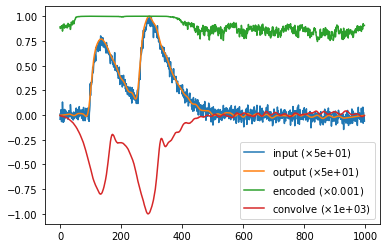

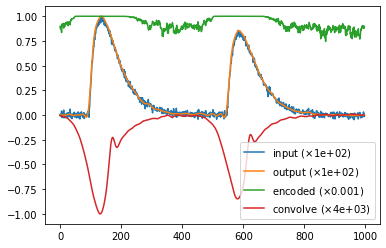

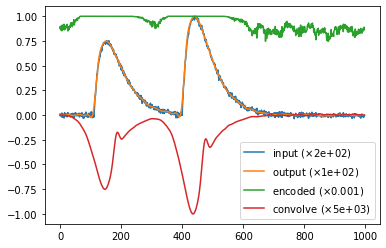

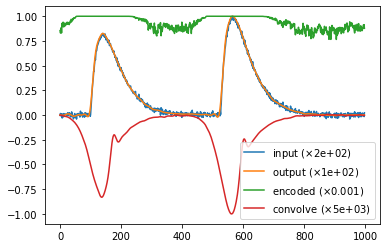

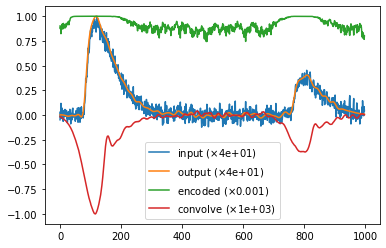

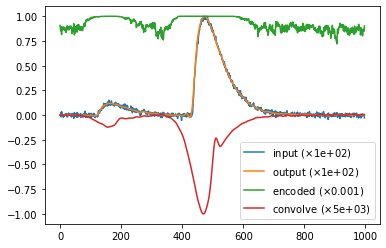

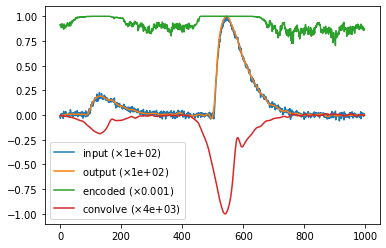

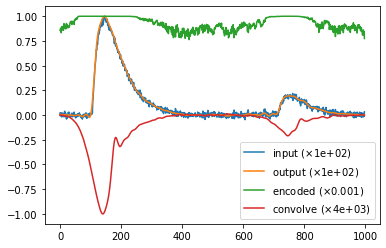

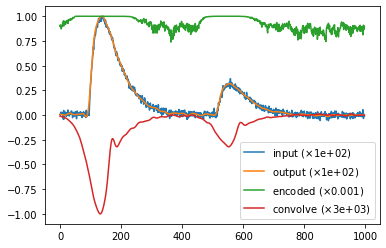

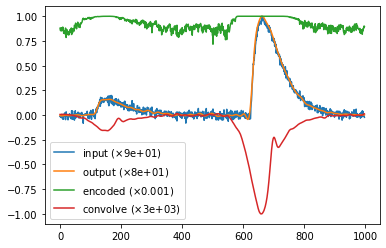

In [18]:
def plot_line(data, label):
  scale = max(data.max(), -data.min())
  return plt.plot(data / scale, label=f"{label} ($\\times${scale:.01})")

def plot_prediction(model, input):
  output = model(input.to(device))
  plot_line(input[0], label="input")
  plot_line(output[0].detach().cpu().numpy(), label="output")
  plot_line(activations["encode"][0].cpu(), label="encoded")
  plot_line(activations["convolve"][0].cpu(), label="convolve")
  plt.legend()

for i in np.random.randint(len(data), size=10):
  plt.figure()
  plot_prediction(model, ds[i][0])

In [ ]:
for n, p in model.named_parameters():
  print(n, p)

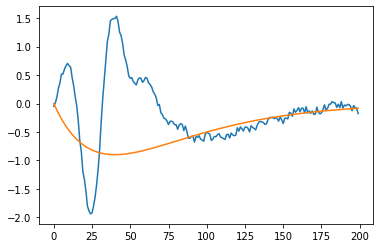

In [22]:
learnt = model.get_parameter("convolve.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)
expected = wps.simple(np.arange(200), 40)
expected = expected / expected[100]* learnt[100]
plt.plot(expected)

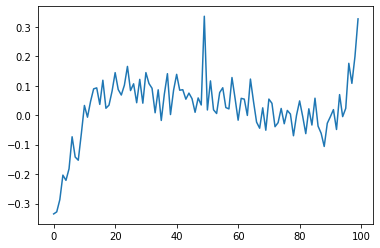

In [23]:
learnt = model.get_parameter("encode.pulse_finder.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)

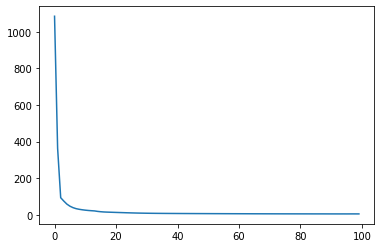

In [21]:
plt.plot(train_test_runner.train_loss);